# “Learning about Machine Learning with CRIM”


**Abstract**

In this tutorial-essay I will consider how we can use machine learning, speciﬁcally dimensionality reduction and embedding methods, with the CRIM corpus. The guiding question is how style can be modeled quantitatively. Building both on music-theoretical conceptualization and machine learning techniques, it will be demonstrated that unsupervised clustering can serve to some degree as a proxy for stylistic similarity. The CRIM data set provides an ideal case study that will also point to some shortcomings of the computational methodology that can only be resolved by a critical view, drawing on musicological expertise and close-reading of sources.


<div class="alert alert-block alert-info">
    <p>
        <b>Key concepts</b>
    </p>
    <p>
        In this tutorial, you will learn about
    </p>
    <ul>
        <li>Regular Expressions</li>
        <li>Vector-space model</li>
        <li>Line of fifths</li>
        <li>Dimensionality reduction</li>
        <li>Clustering</li>
    </ul>
</div>

## Introduction: setting the scope

Questions of style - similarities
Here: Basic approach with a simple representation, important: in principle extensible with other datasets, and more fine-grained concepts

## Setup and obtaining the data

We begin by installing the CRIM intervals library. 

```{bash}
pip install --upgrade --force-reinstall git+https://github.com/HCDigitalScholarship/intervals.git@main 
```


Next we import all libraries and modules that we will need for our subsequent analyses.

In [245]:
abs_path = "/home/fmoss/GitHub/fabianmoss/crim-haverford/" # absolute path to my working directory

import os, glob # file I/O
from tqdm import tqdm # status bar for loops
import re # regular expressions
import requests # to download files

import intervals as ci # crim intervals
# import music21 as m21
import pandas as pd # to work with tabular data

import matplotlib.pyplot as plt # plots, plots, plots
import seaborn as sns
sns.set_context("notebook")
w = 10
figsize = (w, w/1.333)

# dimensionality reduction
from sklearn.decomposition import PCA
from umap import UMAP

We now access the CRIM corpus and download it to our working directory, so that we have to download it only once.
First we get a list of the URLs pointing to each piece in the corpus following the instructions [here](https://github.com/RichardFreedman/CRIM_JHUB/blob/main/Make-me-a-Corpus.ipynb) and [here](https://github.com/RichardFreedman/CRIM_JHUB/blob/main/CRIM_04b_Cadences_Corpus.ipynb).

In [2]:
raw_prefix = "https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/"
URL = "https://api.github.com/repos/CRIM-Project/CRIM-online/git/trees/990f5eb3ff1e9623711514d6609da4076257816c"
piece_json = requests.get(URL).json()
piece_list = [raw_prefix + p["path"] for p in piece_json["tree"]]

The variable `piece_list` now contains all URLs and names of files in the CRIM corpus. We can inspect the first 5 items: 

In [3]:
piece_list[:5]

['https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_1.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_2.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_3.mei',
 'https://raw.githubusercontent.com/CRIM-Project/CRIM-online/master/crim/static/mei/MEI_4.0/CRIM_Mass_0001_4.mei']

In total, we have `len(piece_list)` pieces: 

In [4]:
len(piece_list)

307

There are 307 files in total. Downloading the files takes a certain amount of time. To speed this up, we save all files in `piece_list` in our local directory.

First, we create a new directory `data/` but only if it does not already exist.

In [8]:
d = "data/"
if not os.path.exists(d):
    os.makedirs(d)

Next, we iterate over `piece_list`, request the file from the server and save it to that directory.

In [13]:
for piece in tqdm(piece_list):
    filename = piece.split("/")[-1] # only the part after the last '/' is the filename    
    with open(d + filename, "w") as f:
        # if not os.path.isfile(d + filename):
        r = requests.get(piece)
        f.write(r.text)

100%|█████████████████████████████████████████| 307/307 [02:18<00:00,  2.22it/s]


We create a new list `local_files` containing all local file paths and names.

In [425]:
local_files = glob.glob("data/*.mei")

So now we have a list of file names pointing to MEI files in our local `data/` directory. At a closer look you'll see that some of them end in something like `0001_1.mei` but a few others end in `0001.mei`. There is a pattern to this. The files without the trailing digit are 'wrappers' that bind all movements (indexed 1 through 9) of a particular mass (indexed 0001 through 9999) together. Since these wrappers do not contain any notes or cadences (those are stored in the MEI files of the respective movements), we'll filter them out. 

Fortunately, this is very easy since the filenames are chosen systematically. We only need to remove all files from the `local_files` list that have a file name ending in `_d.mei`, where `d` stands for any integer from 1 to 9.

In [115]:
local_files = [ f  for f in local_files if re.match(r".+_\d.mei$", f) ]

What happened here? We defined a pattern according to which we were able to remove the wrapper file names. This pattern is here expressed as a **regular expression**: `r".+_\d.mei$"`

Let's take it apart to understand how it works.
As you probably now, strings in Python are surrounded by either one or two quotation marks (`'` or `"`). The `r` prefixed to the expression tells the interpreter that the string enclosed in quotes is a regular expression and that the characters have to be interpreted accordingly. 

Next, we see a period `.`. This symbol stands for "any character" in a regular expression. The following `+` means "one or more", so that the combination `.+` stands for a sequence of any characters of length at least 1. With this, we capture the part of the filename preceding the underscore `_`. 

Since the pattern differs towards the end of the file names, we can also view it from the end: The `$` sign marks the end of the string, so that everything to its left has to come just before. Since we are dealing with MEI files, each file name ends with `.mei`, which is exactly what we see before the `$`. 

Now the crucial part. The 'wrapper' files do not have an underscore followed by a single-digit integer. We can use this information and represent that integer with `\d`. 

You can test matching text with regular expressions here: https://regexr.com/ 

Consequently, filenames **not** following this pattern (not being captured by the regular expression) will not be taken into account. In English, we could read the list comprehension for `local_files` as: "make a list of filenames where each filename conforms to the pattern defined by the regular expression".

These are the 5 first movements in the list:

In [116]:
local_files[:5]

['data/CRIM_Mass_0001_1.mei',
 'data/CRIM_Mass_0001_2.mei',
 'data/CRIM_Mass_0001_3.mei',
 'data/CRIM_Mass_0001_4.mei',
 'data/CRIM_Mass_0001_5.mei']

As it turns out, they are not in lexicographical order. This can be easily fixed with the following line of code.

In [117]:
local_files = sorted(local_files)

In [118]:
local_files[:5]

['data/CRIM_Mass_0001_1.mei',
 'data/CRIM_Mass_0001_2.mei',
 'data/CRIM_Mass_0001_3.mei',
 'data/CRIM_Mass_0001_4.mei',
 'data/CRIM_Mass_0001_5.mei']

In [119]:
len(local_files)

219

Apparently, there are "only" 220 individual mass movements. 

In [120]:
print(local_files[17])
del local_files[17] # contains encoding errors?

data/CRIM_Mass_0004_4.mei


## Transforming the data

Now that we have all files nicely stored in our local directory, it is finally time to access them and transform them from the MEI encoding into a tabular format. The CRIM intervals library (imported as `ci`, see above) provides a convenient way to do so: we create a `corpus` by passing a list of files to the `CorpusBase` object.

In [114]:
corpus = ci.CorpusBase([abs_path + f for f in local_files]) # this takes a while...

Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0004_4.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0004_5.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0005_1.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0005_2.mei
Successfully imp

Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0021_1.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0021_2.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0021_3.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0021_4.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0021_5.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0022_2.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0023_1.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0023_2.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0023_3.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0023_4.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/dat

Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0044_5.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0045_1.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0045_2.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0045_3.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0045_4.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0045_5.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0046_1.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0046_2.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0046_3.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0046_4.mei
Successfully imported /home/fmoss/GitHub/fabianmoss/crim-haverford/dat

The `corpus` object now provides a range of convenient methods to access and transform the data further.
For instance, we can access all cadences from the first score `.scores[0]` in the corpus using the `.cadences()` method as follows:

In [24]:
corpus.scores[0].cadences()

,CadType,LeadingTones,CVFs,Low,RelLow,Tone,RelTone,TSig,Measure,Beat,Sounding,Progress,SinceLast,ToNext
28.0,Clausula Vera,0,CT,D3,-P4,D,P5,4/2,4,3.0,4.0,0.118644,28.0,12.0
40.0,Authentic,0,TCB,D3,-P4,D,P5,4/2,6,1.0,4.0,0.169492,12.0,16.0
56.0,Authentic,0,CB,B-3,m3,D,P5,4/2,8,1.0,4.0,0.237288,16.0,16.0
72.0,Authentic,1,CTB,G3,P1,G,P8,8/2,10,1.0,4.0,0.305085,16.0,56.0
128.0,Authentic,0,CB,G3,P1,G,P8,4/2,16,1.0,3.0,0.542373,56.0,8.0
136.0,Clausula Vera,0,TC,G3,P1,G,P8,4/2,17,1.0,4.0,0.576271,8.0,8.0
144.0,Authentic,0,CTB,D3,-P4,D,P5,4/2,18,1.0,4.0,0.610169,8.0,48.0
192.0,Clausula Vera,1,CT,G3,P1,G,P8,4/2,23,1.0,3.0,0.813559,48.0,16.0
208.0,Clausula Vera,0,TC,G3,P1,G,P8,4/2,25,1.0,4.0,0.881356,16.0,28.0
236.0,Authentic,1,CTB,G3,P1,G,P8,10/2,28,3.0,4.0,1.000000,28.0,16.0


## The vector-space model

**In the _vector-space model_, counts of terms are represented in a high-dimensional abstract space. Imagine that terms are stored in a vocabulary with $V$ entries, then the (relative) frequency of these terms in a document (here: in a mass movement) is represented by a real number.**

### $n$-gram models

The concept of $n$-grams is useful to describe sequences of different lengths. 

It comes from the field of _Formal Language Theory_ (FLT). Imagine we have two sequences (e.g., melodies), 
$$s_1 = n_1 n_2 \ldots n_k$$
and 
$$s_2 = n_1 n_2 \ldots n_l,$$
and both melodies are taken from a corpus within the same style. We can then as questions like, which melody is more likely (= more frequent)? 

$$P(s_1) \geq P(s_2).$$

Moreover, this model $n$-gram models let us ask questions like "Given a particular sequence (melody) $s=n_1\ldots n_t$, what is the most likely next note?:"

$$P(n_{t+1}| n_1 \ldots n_t)$$

In the above expression, the probability of the note $n_{t+1}$ depends on the entire "history" of the previous notes in the melody. For a handful of notes, this is not a problem, but it can become difficult to calculate when sequences get very long. This is where the so-called _Markov assumption_ enters the stage:

$$P(n_{t+1}| n_1 \ldots n_t) \approx P(n_{t+1}| n_t).$$

It states that the probability of the next note in the melody, $n_{t+1}$, given the entire previous melody $n_1 \ldots n_t$ can be **approximated** by just looking at the probability of the next note $n_{t+1}$ given the last note $n_t$. We approximate entire melodies by only looking at pairs of notes! These are called **bigrams**. While this seems to be a drastic reduction of complexity (and it is!), it does work quite well in practice.

The $n$ in $n$-gram model determines the length of the history taken into account:
- **unigrams** ($n=1$) take a history of length 0 into account (these are just the raw frequencies of occurrence)
- **bigrams** ($n=2$) take a history of one note into account
- **trigrams** ($n=3$) take a history of two notes into account
- etc.

In [306]:
from collections import Counter

In [479]:
counters = [] # collects the note counts for each piece
finals = [] # collects the lowest note at the end of each piece

for score in tqdm(corpus.scores):
    c = Counter()
    finals.append(score.lowLine().iloc[-1][:-1])
    for n in score.analyses["note_list"]:
#         if n.note.name == "B#":
#             print(score.path)
#             print(n.note.name)
        c[n.note.name] += n.note.duration.quarterLength
    counters.append(c)

100%|█████████████████████████████████████████| 219/219 [00:12<00:00, 17.14it/s]


In [480]:
finals[:20]

['G',
 'G',
 'G',
 'D',
 'G',
 'G',
 'G',
 'G',
 'G',
 'D',
 'F',
 'F',
 'F',
 'F',
 'F',
 'D',
 'G',
 'G',
 'F',
 'C']

In [481]:
note_counts = pd.DataFrame(counters)
note_counts.head()

,G,F,A,B-,C,D,F#,rest,E,C#,B,E-,G#,A-,D-,D#,A#,F-,B#
0,253.5,81.5,110.5,85.0,55.0,234.5,6.0,90.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,506.0,300.5,292.0,264.0,168.0,564.5,18.0,382.0,136.0,18.5,0.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,575.0,492.0,461.0,432.0,311.0,792.5,22.5,818.0,194.0,32.0,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,548.5,283.5,313.0,256.5,187.5,588.5,16.0,634.0,205.5,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,198.0,96.0,99.0,106.0,70.0,236.0,6.0,166.0,58.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [482]:
lof = ["E-", "B-"] + [ n + acc for acc in ["", "#"] for n in list("FCGDAEB") ] # line of fifths

# complete columns
for l in lof:
    if l not in note_counts.columns:
        note_counts[l] = 0.

note_counts = note_counts[lof].fillna(0.) # sort tpcs and drop rests; fill NaNs with zeroes
note_counts.head()

,E-,B-,F,C,G,D,A,E,B,F#,C#,G#,D#,A#,E#,B#
0,0.0,85.0,81.5,55.0,253.5,234.5,110.5,48.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,264.0,300.5,168.0,506.0,564.5,292.0,136.0,0.5,18.0,18.5,0.0,0.0,0.0,0.0,0.0
2,29.0,432.0,492.0,311.0,575.0,792.5,461.0,194.0,0.0,22.5,32.0,0.0,0.0,0.0,0.0,0.0
3,0.0,256.5,283.5,187.5,548.5,588.5,313.0,205.5,0.0,16.0,26.0,0.0,0.0,0.0,0.0,0.0
4,0.0,106.0,96.0,70.0,198.0,236.0,99.0,58.0,0.0,6.0,8.0,0.0,0.0,0.0,0.0,0.0


In [465]:
note_counts.to_csv("note_counts.csv", index=False)

In [483]:
note_counts = pd.read_csv("note_counts.csv")
note_counts.head()

,E-,B-,F,C,G,D,A,E,B,F#,C#,G#,D#,A#,E#,B#
0,0.0,85.0,81.5,55.0,253.5,234.5,110.5,48.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,264.0,300.5,168.0,506.0,564.5,292.0,136.0,0.5,18.0,18.5,0.0,0.0,0.0,0.0,0.0
2,29.0,432.0,492.0,311.0,575.0,792.5,461.0,194.0,0.0,22.5,32.0,0.0,0.0,0.0,0.0,0.0
3,0.0,256.5,283.5,187.5,548.5,588.5,313.0,205.5,0.0,16.0,26.0,0.0,0.0,0.0,0.0,0.0
4,0.0,106.0,96.0,70.0,198.0,236.0,99.0,58.0,0.0,6.0,8.0,0.0,0.0,0.0,0.0,0.0


In [487]:
pd.Series(finals).to_csv("finals.csv", index=False, header=False)

In [475]:
pd.Series(finals).to_csv("finals.csv", index=False, header=False)
# finals = pd.read_csv("finals.csv")
# finals = finals[0]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Term frequencies

### Document frequencies

### Term frequency - inverse document frequency (TF-IDF)

In [388]:
import numpy as np

# dia = ["B-"] + list("FCGDAEB") + ["Rest"]

cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(lof)))

clrs = [ colors[lof.index(l)] for l in note_counts.idxmax(axis=1)]

# clrs = [colors[lof.index(l)] for l in note_counts.idxmax(axis=1).apply(lambda x: x[:-1] if x[-1] != "t" else x).values]

## Dimensionality reduction

In [389]:
X = note_counts.values

TEXT

We start of with our data in $\text

### The idea

### Principal Components Analysis (PCA): a simple and popular method

In [390]:
pca_reducer = PCA(n_components=2)

In [391]:
X_ = pca_reducer.fit_transform(X)

In [392]:
def plot_embedding(emb, axes=True):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('equal')
    ax.scatter(emb[:,0], emb[:,1], alpha=.75, zorder=3, c=clrs)
    for (x, y), s in zip(emb, note_counts.index):
        ax.text(x, y, s, fontsize=10)
    if axes:
        ax.axhline(0, lw=.5, c="k")
        ax.axvline(0, lw=.5, c="k")
    # plt.show()

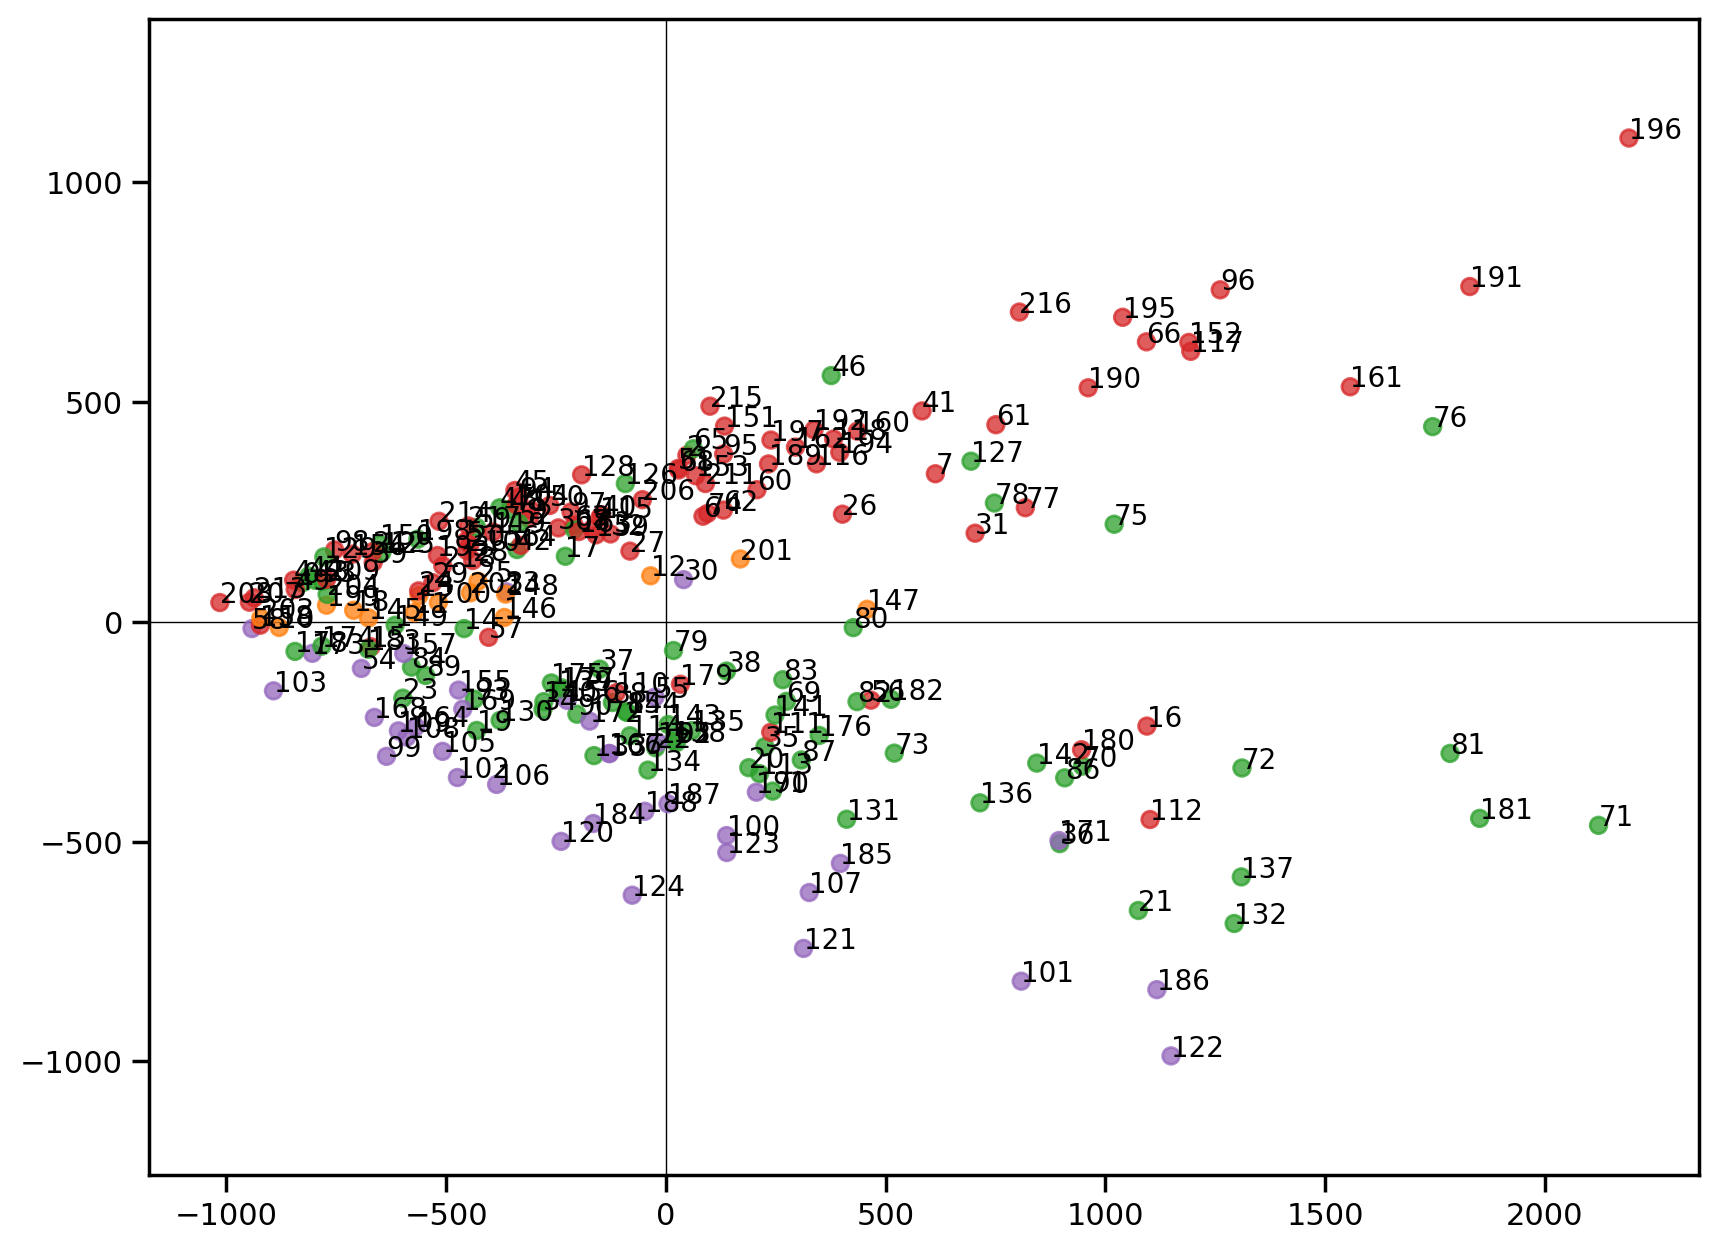

In [393]:
plot_embedding(X_)

### Relative frequencies

In [394]:
rel_note_counts = note_counts.div(note_counts.sum(axis=1), axis=0)
rel_note_counts.head()

,E-,B-,F,C,G,D,A,E,B,F#,C#,G#,D#,A#,E#,B#
0,0.000000,0.097254,0.093249,0.062929,0.290046,0.268307,0.126430,0.054920,0.00000,0.006865,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.001761,0.116197,0.132262,0.073944,0.222711,0.248460,0.128521,0.059859,0.00022,0.007923,0.008143,0.0,0.0,0.0,0.0,0.0
2,0.008680,0.129303,0.147261,0.093086,0.172104,0.237204,0.137983,0.058066,0.00000,0.006735,0.009578,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.105773,0.116907,0.077320,0.226186,0.242680,0.129072,0.084742,0.00000,0.006598,0.010722,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.120867,0.109464,0.079818,0.225770,0.269099,0.112885,0.066135,0.00000,0.006842,0.009122,0.0,0.0,0.0,0.0,0.0


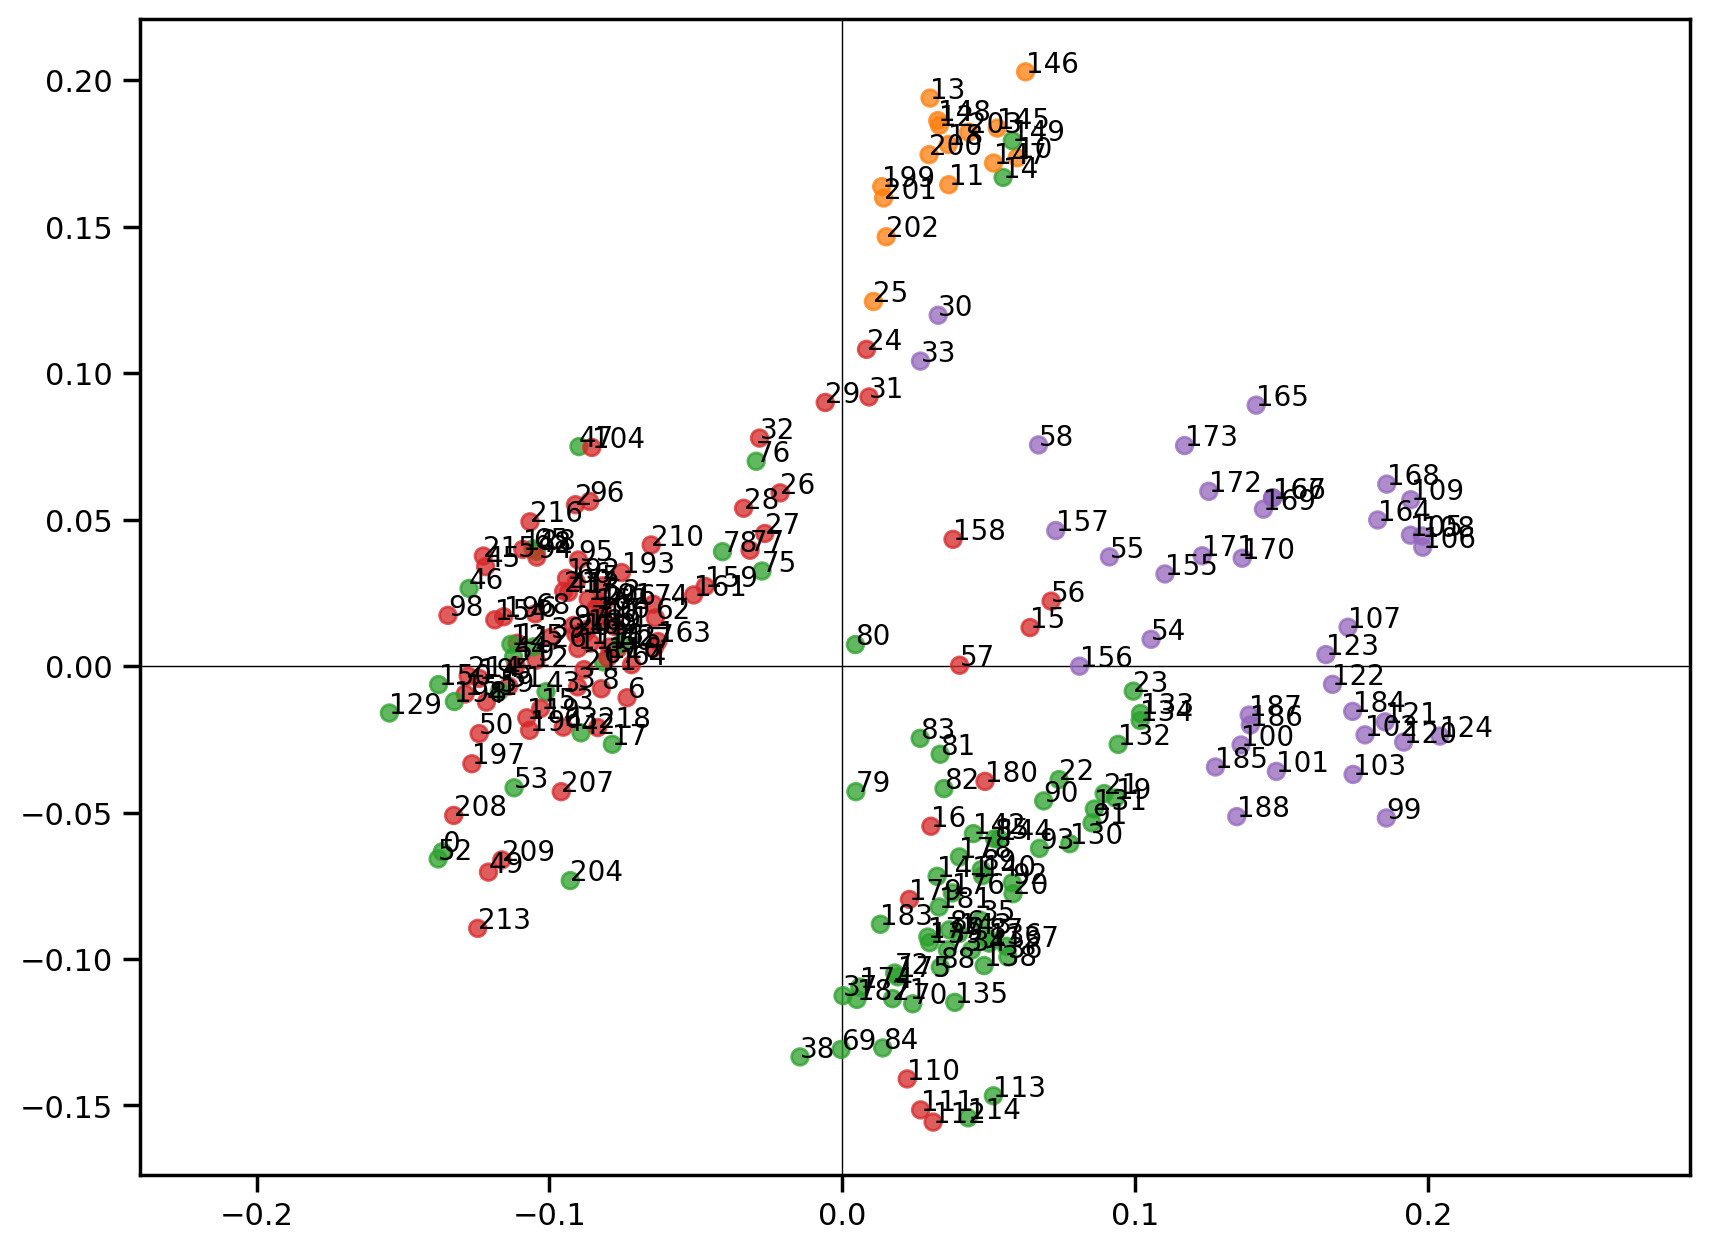

In [395]:
X__ = pca_reducer.fit_transform(rel_note_counts.values)
plot_embedding(X__)

### Finding clusters

In [396]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4)
clusterer.fit(X__)

KMeans(n_clusters=4)

In [397]:
clusterer.cluster_centers_

array([[ 0.03124276,  0.14589237],
       [ 0.14265898,  0.01179948],
       [-0.09258113,  0.00732943],
       [ 0.03960879, -0.08481953]])

In [411]:
cluster_clrs = np.array(clrs)[[ np.where(clusterer.labels_ == i)[0][2] for i in range(4) ]]
cluster_clrs

array([[1.        , 0.49803922, 0.05490196, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ]])

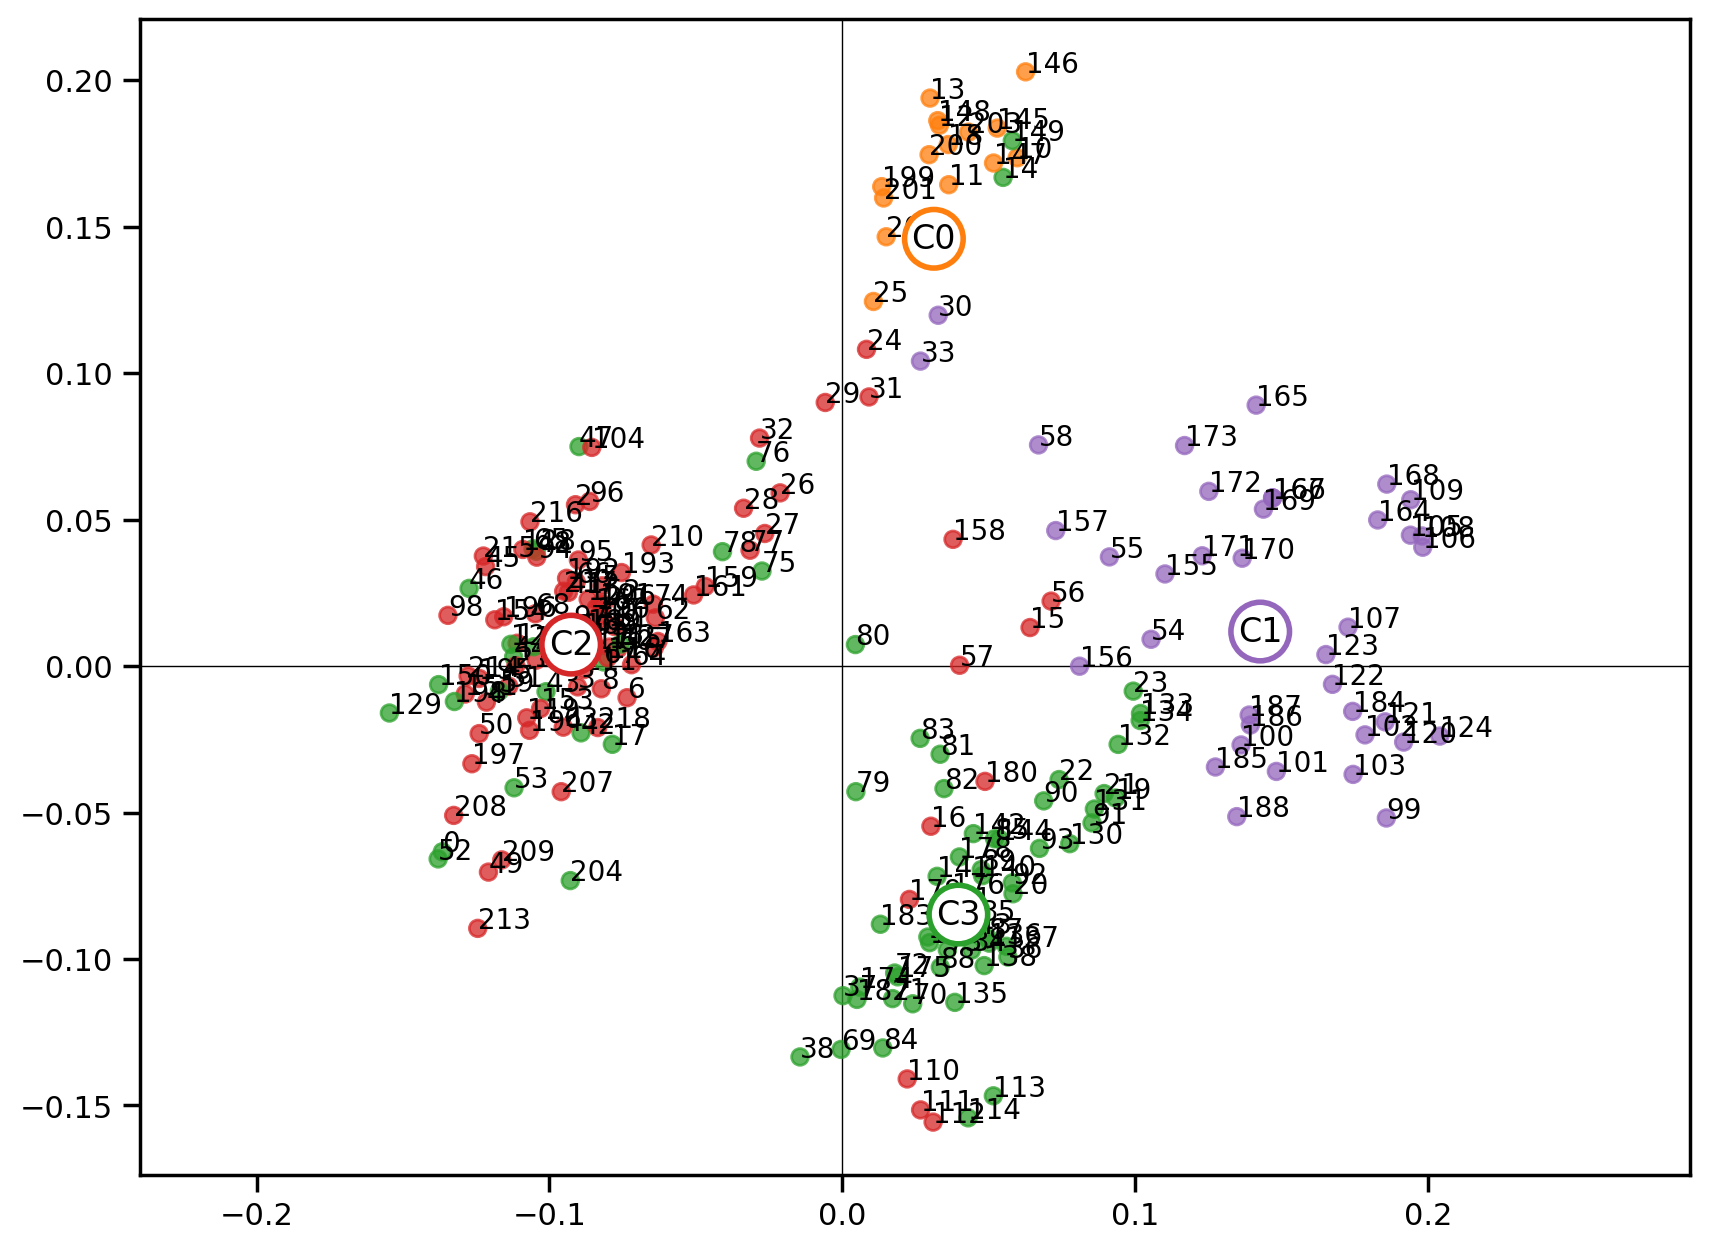

In [420]:
from matplotlib.patches import Circle

plot_embedding(X__)
for i, ((x,y), c) in enumerate(zip(clusterer.cluster_centers_, cluster_clrs)):
    circ = Circle(
        xy=(x,y), 
        radius=.01, 
        edgecolor=c, 
        linewidth=2, 
        facecolor="white", 
        zorder=3
    )
    ax = plt.gca()
    ax.add_patch(circ)
    plt.text(x, y, f"C{i}", fontsize=12, va="center", ha="center", zorder=4)

Some observations: 
- The first principal component (PC1) separates cluster C2 (final G) from all other clusters.
- The second principal component (PC2) separates cluster C3 (final C) from all other clusters.

--> 

### Note distributions within clusters

In [421]:
df = rel_note_counts
df["cluster"] = clusterer.labels_

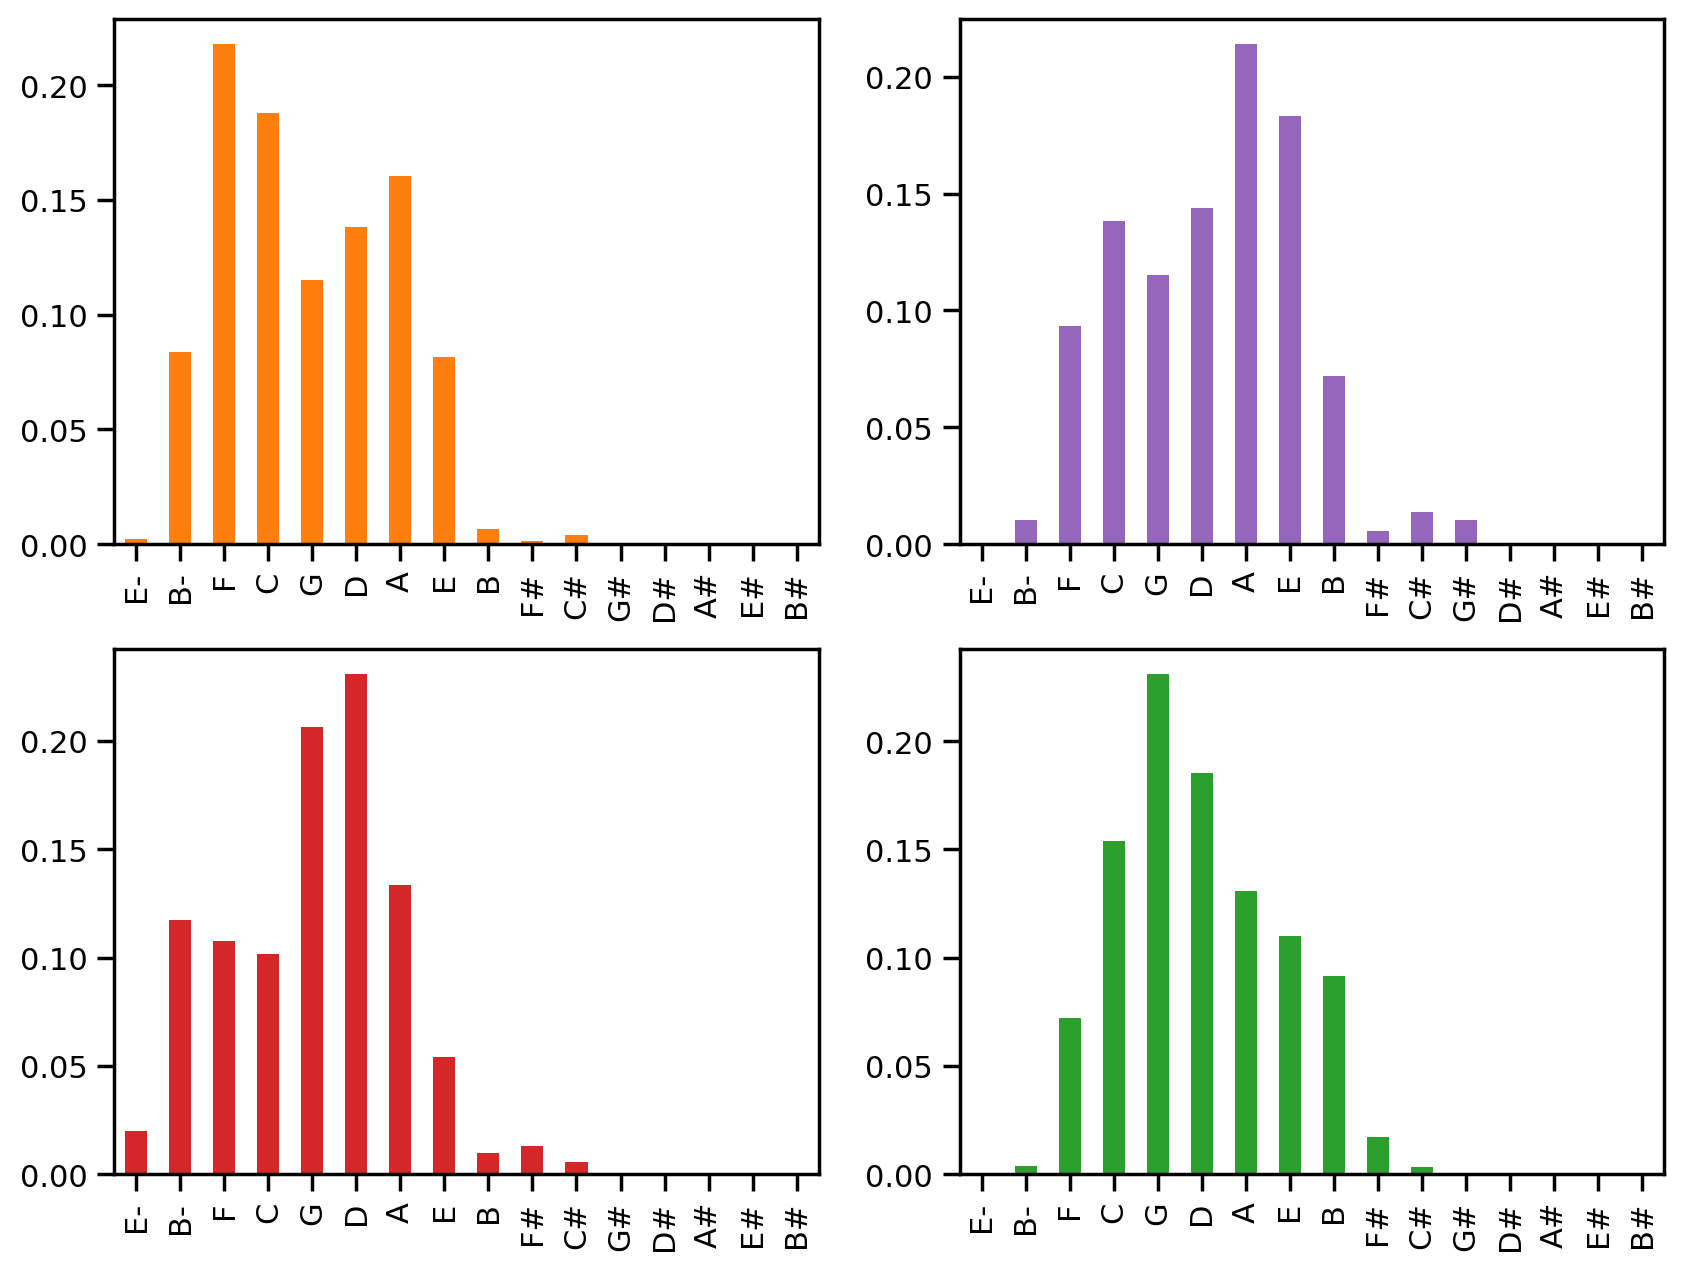

In [423]:
means = df.groupby("cluster").mean()

fig, axes = plt.subplots(2,2, figsize=figsize)
axes = axes.flatten()
for i, m in means.iterrows():
    m.plot(kind="bar", ax=axes[i], color=cluster_clrs[i])

#### Some oddities

- D# -- B# ?!

In [281]:
note_counts.sum(axis=0).round(2)

E-      6220.17
B-     42535.50
F      73554.67
C      93609.50
G     132128.08
D     135186.08
A     105802.92
E      69071.58
B      32199.17
F#      8009.50
C#      4359.00
G#      1487.00
D#         4.00
A#         2.00
E#         0.00
B#         9.00
dtype: float64

Apparently, there are 4 quartes of D#'s, 2 quarters of A#'s and even 9 quarters of B#'s. In which pieces can they be found?

In [273]:
odd_notes = note_counts[
    (note_counts["D#"] > 0) |\
    (note_counts["A#"] > 0) |\
    (note_counts["B#"] > 0)
]
odd_notes

,E-,B-,F,C,G,D,A,E,B,F#,C#,G#,D#,A#,E#,B#
114,0.0,0.0,4.0,299.5,652.5,631.0,435.5,339.5,423.5,233.5,16.0,0.0,4.0,0.0,0.0,0.0
128,41.0,487.5,287.0,316.5,545.0,558.0,328.0,151.0,1.0,39.0,14.0,0.0,0.0,2.0,0.0,0.0
161,71.0,664.0,819.0,611.5,1177.0,1815.5,1315.0,573.0,40.0,110.0,139.0,0.0,0.0,0.0,0.0,8.0
173,0.0,43.0,142.0,107.0,71.0,201.0,308.0,184.0,48.0,5.0,39.0,10.0,0.0,0.0,0.0,1.0


In [277]:
odd_notes.index.values

array([114, 128, 161, 173])

In [282]:
odd_files = np.array(local_files)[odd_notes.index.values]
odd_files

array(['data/CRIM_Mass_0025_1.mei', 'data/CRIM_Mass_0027_5.mei',
       'data/CRIM_Mass_0036_4.mei', 'data/CRIM_Mass_0042_1.mei'],
      dtype='<U25')

In [283]:
import music21 as m21

In [305]:
for i, n in enumerate(m21.converter.parse(odd_files[-1]).flatten().notes):
    if "#" in n.name:
        print(n)

<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note C#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note C#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>


--> There is no B#, so how could it have ended up in the df?

In [312]:
o = "/home/fmoss/GitHub/fabianmoss/crim-haverford/data/CRIM_Mass_0039_5.mei"

In [313]:
for i, n in enumerate(m21.converter.parse(o).flatten().notes):
    if "#" in n.name:
        print(n)

<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note G#>
<music21.note.Note G#>
<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note F#>
<music21.note.Note G#>
<music21.note.Note C#>
<music21.note.Note C#>


#### A "neutral" piece?

In [424]:
local_files[80]

'data/CRIM_Mass_0017_3.mei'

Missa Baisiez moy: Credo, by Mathurin Forestier

## On style

Meyer quote

## References

- Jurafsky, D. & Martin, J. H. (2014). _Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition_ (2nd ed.). Pearson.
- Kastorp, F., Kestemont, M., & Riddell, A. (2022). _Humanities Data Analysis: Case Studies with Python_. Princeton University Press. https://www.humanitiesdataanalysis.org/vector-space-model/notebook.html
- Meyer, L. B. (1989). _Music and Styles: Theory, History, and Ideology_. Chicago University Press.